In [1]:
# ML_in_Finance-Autoencoders
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

# Introduction

The purpose of this notebook is to first review PCA for yield curve dimension reduction. Linear autoencoders are then compared with PCA. Finally we evaluate deep autoencoders for yield curve compression.

# PCA
Principal component analysis requires finding the weights which maximize the maximum weighted variance of the data $Y$: 
$$\max_{w:||w||=1}Var(w^TY) = \max_{w:||w||=1}w^TVar(Y)w$$

Setting $w=v$, with $v$ the eigenvector corresponding to the largest eigenvalue $\lambda$ of $C:=Var(Y)$ will yield an orthogonal projection which is an optimal solution. From the eigenvalue problem, we can obtain the eigenvalues of $V$:

$$C v=\lambda v$$
$$(C-\lambda I)v=0$$
$$ |C-\lambda I|=0$$

Plugging the eigenvalues into second equation above gives the eigenvectors. The result can be written as:

$$\Lambda=V^TCV,$$

where $\Lambda$ is the diagonal matrix of descending eigenvalues and $P$ is the corresponding orthornormal matrix of eigenvectors. Rearanging gives the spectral decomposition of the covariance matrix.

$$C=P\Lambda P^T$$.

The transformation of Y onto the orthonormal basis spanned by the columns of $P$ is:
$$X=P^TY$$

# Libs & Defs

In [179]:
from keras.layers import Input, Dense
from keras import regularizers, models, optimizers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.decomposition import PCA

In [3]:
%matplotlib inline

In [2]:
# Linear Autoencoder
def LinearAE(y, dimension, learning_rate = 1e-4, regularization = 5e-4, epochs=10):
    input_layer = Input(shape=(y.shape[1],))
    encoded = Dense(dimension, activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(input_layer)
    decoded = Dense(y.shape[1], activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(encoded)
    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer=optimizers.adam(lr=learning_rate), loss='mean_squared_error')
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

In [4]:
!ls

ML_in_Finance-1D-CNNs.ipynb            ML_in_Finance-RNNs-HFT.ipynb
ML_in_Finance-2D-CNNs.ipynb            README.md
ML_in_Finance-Autoencoders.ipynb       __pycache__
ML_in_Finance-RNNs-Bitcoin-Copy1.ipynb alphaRNN.py
ML_in_Finance-RNNs-Bitcoin.ipynb       alphatRNN.py


# Load Dataset

In [4]:
df = pd.read_csv('../data/yield_curve.csv', sep=',')

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

df.set_index('Date', drop=True, inplace=True)

df.index.names = [None]

df.drop('Index', axis=1, inplace=True)

n_obs = len(df)

##### Uncomment the `elif (...)` line to perform PCA on the daily yield changes $\Delta Y_0$:

In [7]:
if len(df) == n_obs - 1: print('differences already taken')
#elif len(df) == n_obs: df, dt = df.diff(1).iloc[1:], df.diff(1).iloc[1:].transpose() 

In [8]:
df.head()

,1M,2M,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
1992-02-29,0.0961,0.09610,0.0961,0.0958,0.0898,0.0864,0.0849,0.0837,0.0826,0.0817,0.0810,0.0806,0.0803,0.0804
1992-03-31,0.0970,0.09700,0.0970,0.0969,0.0912,0.0889,0.0877,0.0864,0.0852,0.0841,0.0833,0.0827,0.0823,0.0823
1992-04-30,0.0975,0.09750,0.0975,0.0975,0.0920,0.0892,0.0877,0.0862,0.0848,0.0837,0.0828,0.0822,0.0817,0.0816
1992-05-31,0.0978,0.09785,0.0979,0.0979,0.0920,0.0889,0.0874,0.0860,0.0847,0.0836,0.0828,0.0821,0.0817,0.0815
1992-06-30,0.0974,0.09745,0.0975,0.0975,0.0931,0.0904,0.0889,0.0874,0.0860,0.0848,0.0839,0.0832,0.0827,0.0825


# Visualizing the Dataset

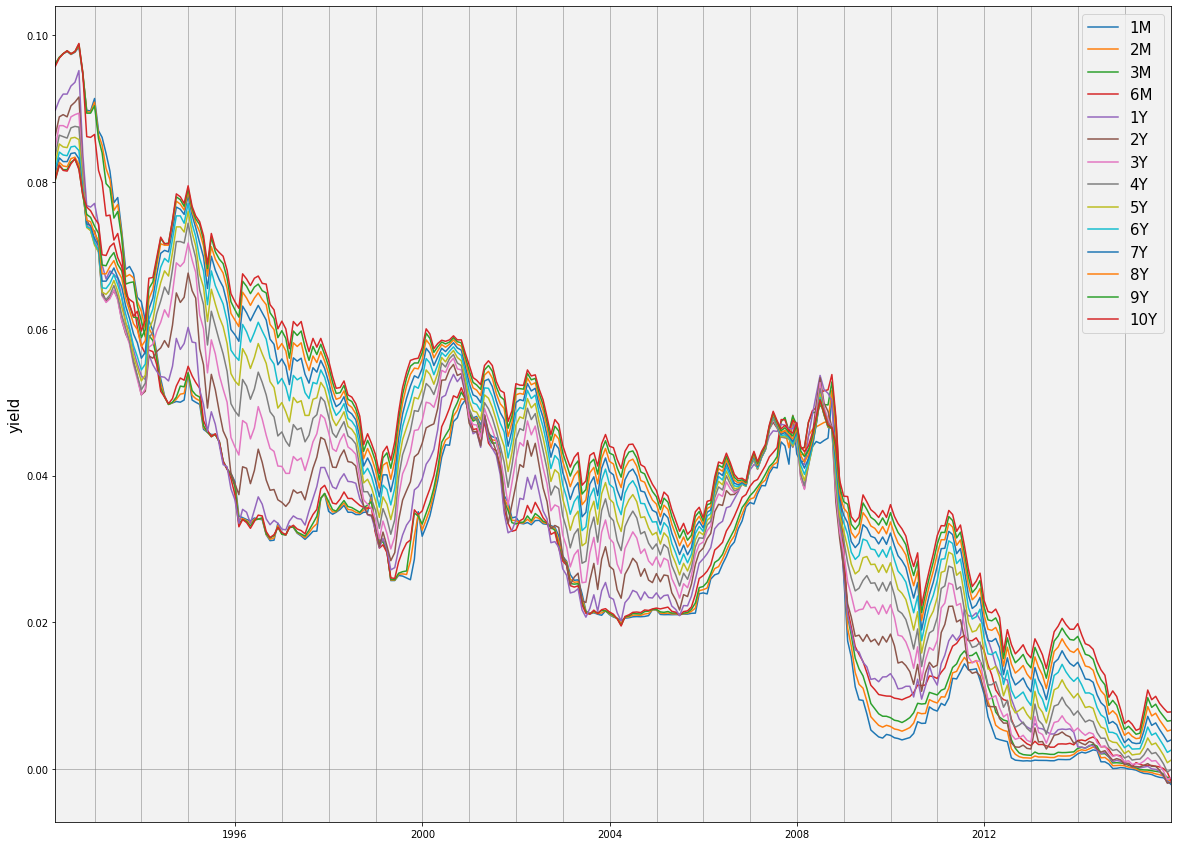

In [180]:
plt.figure(figsize=(20,15))

plt.plot(df.index, df)
plt.xlim(df.index.min(), df.index.max())
plt.ylabel('yield', fontsize=15)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
plt.legend(df.columns, fontsize=15)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=datetime(i, 1, 1), c="grey", linewidth=0.5, zorder=0)

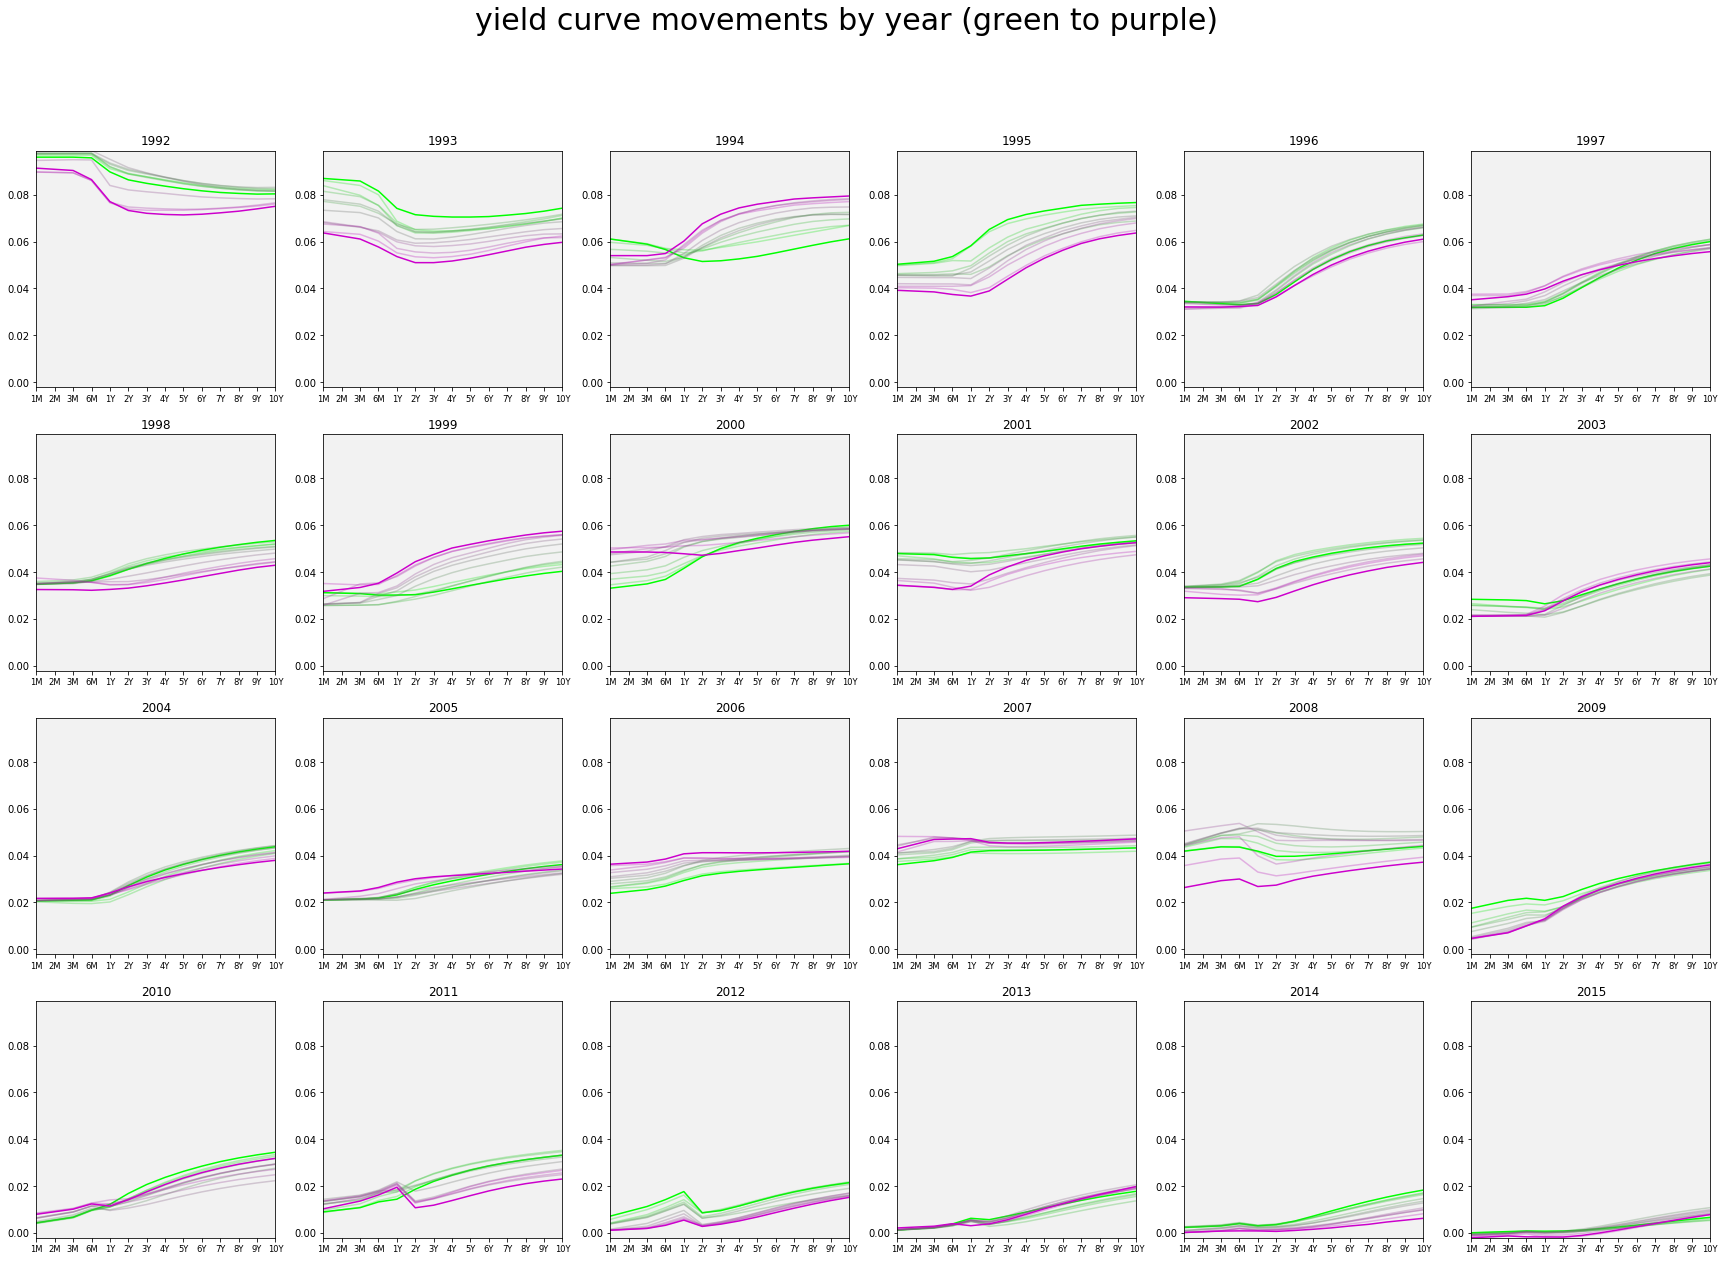

In [181]:
cols = 6
num_years = df.index.max().year - df.index.min().year
rows = int(np.ceil(num_years/cols))

# each line is a yield curve at a given time; each year begins green and ends purple
plt.figure(figsize=(30, (30/cols)*rows))
plt.suptitle('yield curve movements by year (green to purple)', fontsize=30)

colnum = 0
rownum = 0
for year in range(df.index.min().year, df.index.max().year+1):
    year_start = datetime(year, 1, 1)
    year_end = datetime(year, 12, 31)
    
    plt.subplot2grid((rows, cols), (rownum, colnum), colspan=1, rowspan=1)
    plt.title('{0}'.format(year))
    plt.xlim(0, len(df.columns)-1)
    plt.ylim(np.min(df.values), np.max(df.values))
    plt.xticks(range(len(df.columns)), df.columns, size='small')
    
    year_curves = df.loc[year_start:year_end].values    
    gradient = np.linspace([0, 1, 0, 1], [0.8, 0, 0.8, 1], year_curves.shape[0])
    gradient[1:-1, -1] = 0.3
    
    for yield_curve, colour in zip(year_curves, gradient):
        plt.plot(yield_curve, c=colour)

    
    if colnum != cols-1:
        colnum += 1
    else:
        colnum = 0
        rownum += 1

# Projection onto Principal Components

In [5]:
# calculate the first three PCs (Eigenvectors & Eigenvalues of the covariance matrix)
pca_model = PCA(n_components=3, copy=True, whiten=False)
pca_model.fit(df)

# project the dataset onto the principal components
df_pca = pd.DataFrame(pca_model.transform(df))

df_pca.index = df.index
#df_pca.columns = ['PC1', 'PC2', 'PC3']

# transform the projections back into the input space
df_pca_recon = pd.DataFrame(pca_model.inverse_transform(df_pca), index=df.index, columns=df.columns)

In [12]:
np.array((np.mean(df_pca_recon-df)/np.mean(df),np.max(df_pca_recon-df)/np.mean(df))).T

array([[ 9.52072881e-17,  8.42145591e-02],
       [-6.89762792e-17,  3.71764645e-02],
       [-5.41963177e-17,  2.20958347e-02],
       [ 2.05058994e-17,  5.05013313e-02],
       [ 1.82116760e-17,  6.89066826e-02],
       [-3.66061056e-17,  7.82786881e-02],
       [ 9.42522454e-18,  6.59238706e-02],
       [ 3.96801481e-17,  4.12921944e-02],
       [ 6.90339296e-19,  2.55995528e-02],
       [-7.57683740e-17,  1.90901074e-02],
       [ 7.41735770e-17,  1.05613472e-02],
       [-5.02418330e-17,  9.12885158e-03],
       [ 3.81597017e-17,  1.74811721e-02],
       [-1.76098518e-17,  2.82270392e-02]])

In [13]:
df_pca.head()

,0,1,2
1992-02-29,0.189681,0.031657,-0.002092
1992-03-31,0.196655,0.029239,-0.003471
1992-04-30,0.196720,0.031033,-0.003950
1992-05-31,0.196820,0.031674,-0.003434
1992-06-30,0.199527,0.029321,-0.005054


## Evaluate and plot the reconstruction error

In [9]:
mu = np.mean(df.values, axis=0)

centred_data = df.values - mu

pca_transformed = centred_data @ pca_model.components_.T

pca_reconstructed = (pca_transformed @ pca_model.components_) + mu.reshape(1,14)



print('original shape:', centred_data.shape)
print('transformed shape:', pca_transformed.shape)
print('reconstructed shape:', pca_reconstructed.shape)
print('avg error per variable:', np.mean(pca_reconstructed - df.values))


original shape: (287, 14)
transformed shape: (287, 3)
reconstructed shape: (287, 14)
avg error per variable: -2.4177330675634942e-20


In [10]:
# the reconstruction error is the orthogonal distance between each point and the PCA subspace
pca_rec_errs = np.sqrt(np.sum((pca_reconstructed - df)**2, axis=1))
pca_rec_errs.shape

(287,)

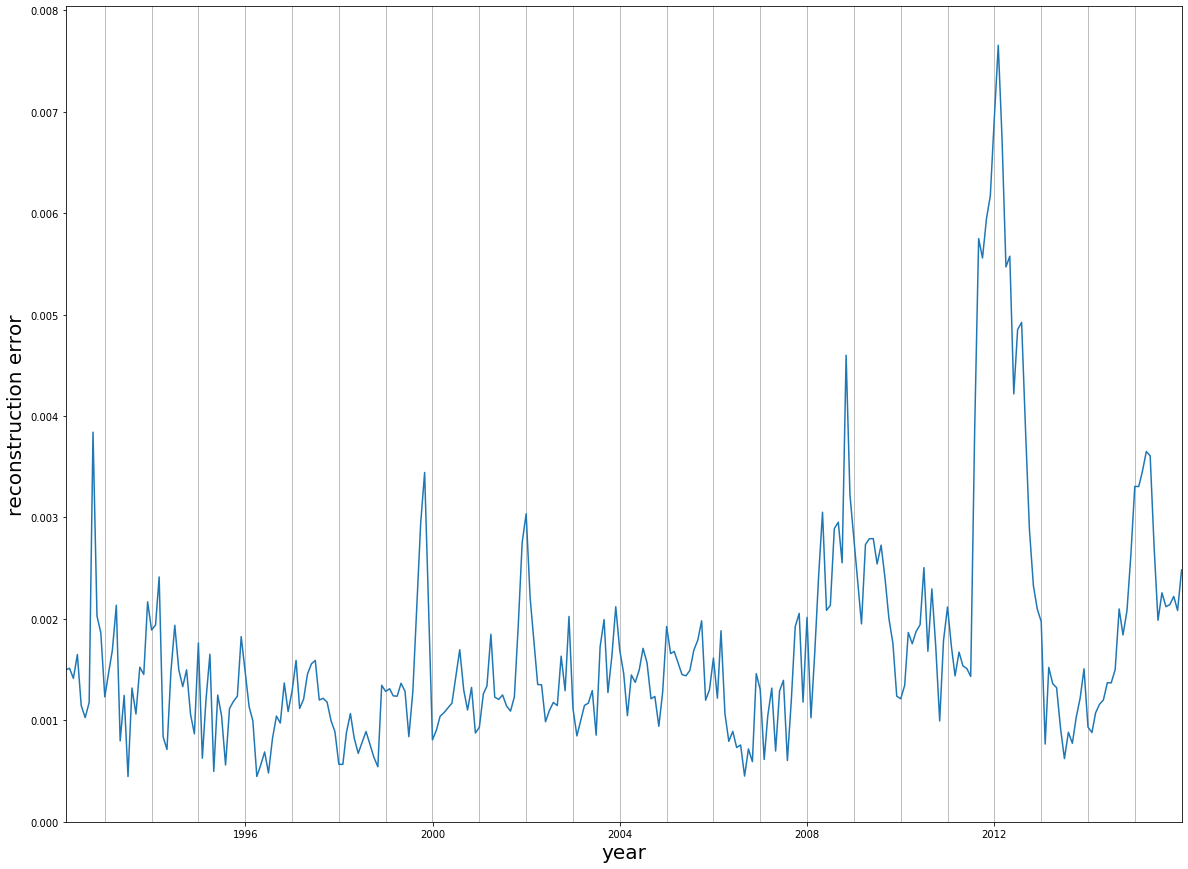

In [11]:
plt.figure(figsize=(20,15))
'''
plt.plot(df.index, pd.DataFrame(Y_recon_pca-df))
plt.xlim(df.index.min(), df.index.max())
# plt.ylim(0, 0.1)
plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)
'''
    
plt.plot(df.index, pca_rec_errs)
plt.xlim(df.index.min(), df.index.max())
plt.ylim(0, pca_rec_errs.max()*1.05)
plt.ylabel('reconstruction error', size=20)
plt.xlabel('year', size=20)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

### Evaluate the amount of variance explained by each component

In [17]:
for i, pc in enumerate(pca_model.explained_variance_ratio_):
    print('PC {0}:\t{1:5.2f}%'.format(i+1, pc*100.0))

PC 1:	95.53%
PC 2:	 4.07%
PC 3:	 0.33%


### Plot the loading vectors

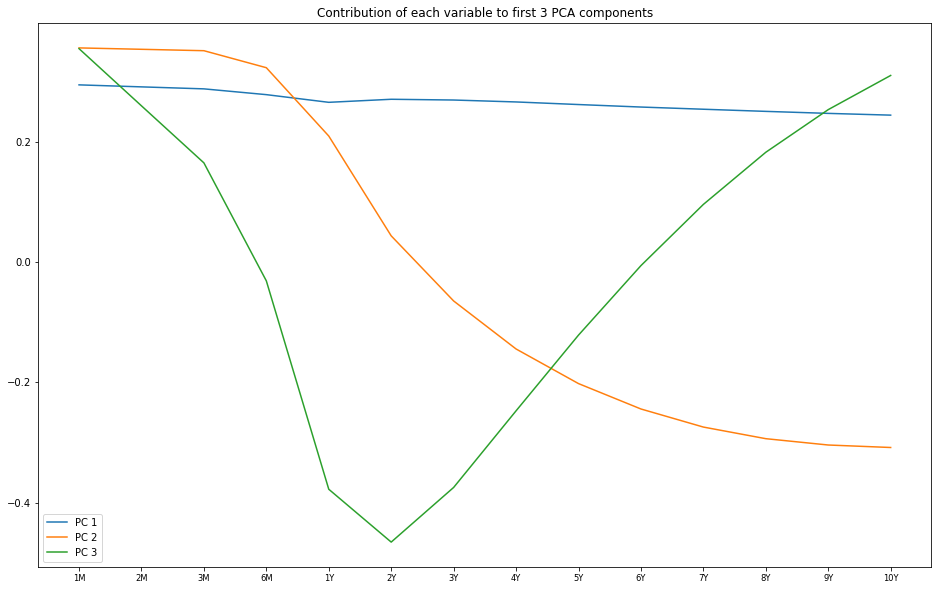

In [18]:
fig = plt.figure(figsize=(16,10))
plt.title('Contribution of each variable to first {0} PCA components'.format(pca_model.components_.shape[0]))

plt.plot(np.transpose(pca_model.components_[0]), label='PC 1')
plt.plot(np.transpose(pca_model.components_[1]), label='PC 2')
plt.plot(np.transpose(pca_model.components_[2]), label='PC 3')
plt.xticks(range(len(df.columns)), df.columns, size='small')

plt.legend() #'upper right')
None

# Linear Autoencoders

### Fit the linear auto-encoder

In [6]:
ae_model = LinearAE(df.values, 3, regularization=0, epochs=300) #¢# epochs=300
(w1, b1, w2, b2) = ae_model.get_weights()

Epoch 1/300
287/287 [==============================] - 2s 6ms/step - loss: 0.0017
Epoch 2/300
287/287 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 3/300
287/287 [==============================] - 0s 1ms/step - loss: 8.9121e-04
Epoch 4/300
287/287 [==============================] - 0s 1ms/step - loss: 6.9897e-04
Epoch 5/300
287/287 [==============================] - 0s 1ms/step - loss: 5.7509e-04
Epoch 6/300
287/287 [==============================] - 0s 1ms/step - loss: 4.9621e-04
Epoch 7/300
287/287 [==============================] - 0s 978us/step - loss: 4.4773e-04
Epoch 8/300
287/287 [==============================] - 0s 971us/step - loss: 4.1774e-04
Epoch 9/300
287/287 [==============================] - 0s 992us/step - loss: 3.9825e-04
Epoch 10/300
287/287 [==============================] - 0s 1ms/step - loss: 3.8466e-04
Epoch 11/300
287/287 [==============================] - 0s 1ms/step - loss: 3.7438e-04
Epoch 12/300
287/287 [==============================] 

287/287 [==============================] - 0s 944us/step - loss: 1.4146e-05
Epoch 95/300
287/287 [==============================] - 0s 862us/step - loss: 1.4002e-05
Epoch 96/300
287/287 [==============================] - 0s 962us/step - loss: 1.3865e-05
Epoch 97/300
287/287 [==============================] - 0s 858us/step - loss: 1.3837e-05
Epoch 98/300
287/287 [==============================] - 0s 866us/step - loss: 1.3615e-05
Epoch 99/300
287/287 [==============================] - 0s 904us/step - loss: 1.3598e-05
Epoch 100/300
287/287 [==============================] - 0s 895us/step - loss: 1.3522e-05
Epoch 101/300
287/287 [==============================] - 0s 838us/step - loss: 1.3437e-05
Epoch 102/300
287/287 [==============================] - 0s 903us/step - loss: 1.3285e-05
Epoch 103/300
287/287 [==============================] - 0s 827us/step - loss: 1.3182e-05
Epoch 104/300
287/287 [==============================] - 0s 875us/step - loss: 1.3120e-05
Epoch 105/300
287/287 [======

287/287 [==============================] - 0s 880us/step - loss: 7.9093e-06
Epoch 186/300
287/287 [==============================] - 0s 805us/step - loss: 7.8454e-06
Epoch 187/300
287/287 [==============================] - 0s 931us/step - loss: 7.8240e-06
Epoch 188/300
287/287 [==============================] - 0s 815us/step - loss: 7.7731e-06
Epoch 189/300
287/287 [==============================] - 0s 823us/step - loss: 7.7219e-06
Epoch 190/300
287/287 [==============================] - 0s 879us/step - loss: 7.6747e-06
Epoch 191/300
287/287 [==============================] - 0s 863us/step - loss: 7.6539e-06
Epoch 192/300
287/287 [==============================] - 0s 874us/step - loss: 7.6294e-06
Epoch 193/300
287/287 [==============================] - 0s 832us/step - loss: 7.6019e-06
Epoch 194/300
287/287 [==============================] - 0s 870us/step - loss: 7.4991e-06
Epoch 195/300
287/287 [==============================] - 0s 834us/step - loss: 7.5215e-06
Epoch 196/300
287/287 [=

287/287 [==============================] - 0s 987us/step - loss: 4.8707e-06
Epoch 278/300
287/287 [==============================] - 0s 970us/step - loss: 4.8958e-06
Epoch 279/300
287/287 [==============================] - 0s 1ms/step - loss: 4.8485e-06
Epoch 280/300
287/287 [==============================] - 0s 957us/step - loss: 4.8109e-06
Epoch 281/300
287/287 [==============================] - 0s 885us/step - loss: 4.8063e-06
Epoch 282/300
287/287 [==============================] - 0s 949us/step - loss: 4.7734e-06
Epoch 283/300
287/287 [==============================] - 0s 931us/step - loss: 4.7194e-06
Epoch 284/300
287/287 [==============================] - 0s 1ms/step - loss: 4.7137e-06
Epoch 285/300
287/287 [==============================] - 0s 1ms/step - loss: 4.7167e-06
Epoch 286/300
287/287 [==============================] - 0s 1ms/step - loss: 4.6613e-06
Epoch 287/300
287/287 [==============================] - 0s 1ms/step - loss: 4.6492e-06
Epoch 288/300
287/287 [===========

### Extract the first singular vectors of the decoder weight matrix
The left singular vectors approximate the PCA loading vectors (up to a sign)

In [13]:
# PCA by applying SVD to linear autoencoder weights
(ae_decoder_svd, _, _) = np.linalg.svd(w2.T, full_matrices=False)

In [14]:
ae_reconstructed = ae_model.predict(df)
#ae_reconstructed = ae_model.predict((df.values-mu)/std + mu.reshape(1,14))*std

In [195]:
np.std((df.values-mu)/std, axis=0
    )

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

True

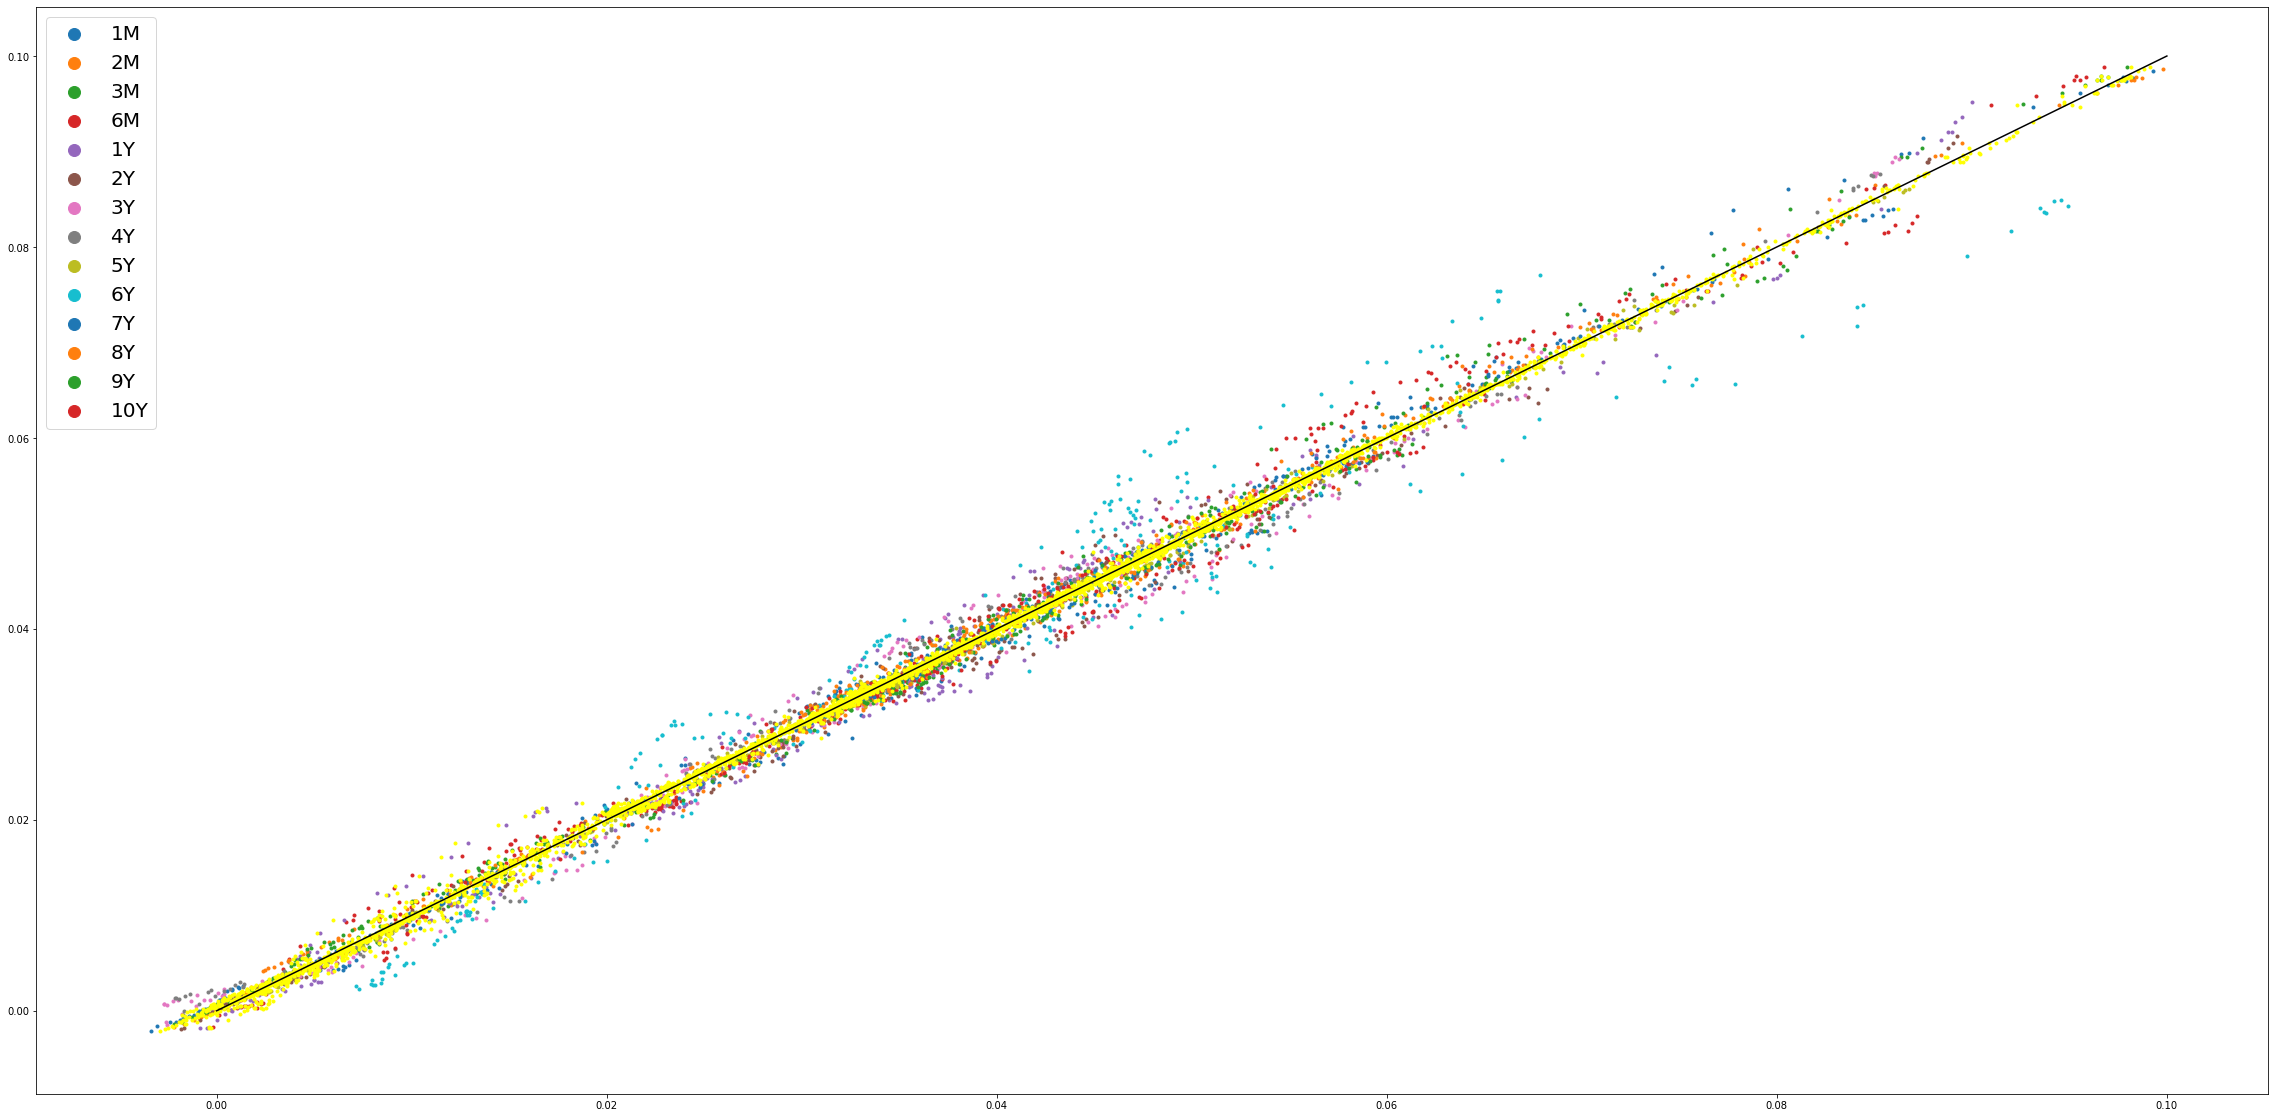

In [164]:
plt.figure(figsize=(40,20))
for i in range(ae_reconstructed.shape[1]):
    plt.scatter(ae_reconstructed[:, i], df.values[:, i], marker='.') # ae recon vs original data
plt.legend(df.columns, markerscale=4, fontsize=20)
plt.plot(np.linspace(0,0.1,100),np.linspace(0,0.1,100),c='black') # y = x
plt.scatter(pca_reconstructed, df, marker='.', c='yellow') # pca preimage vs original data
df.shape==ae_reconstructed.shape

True

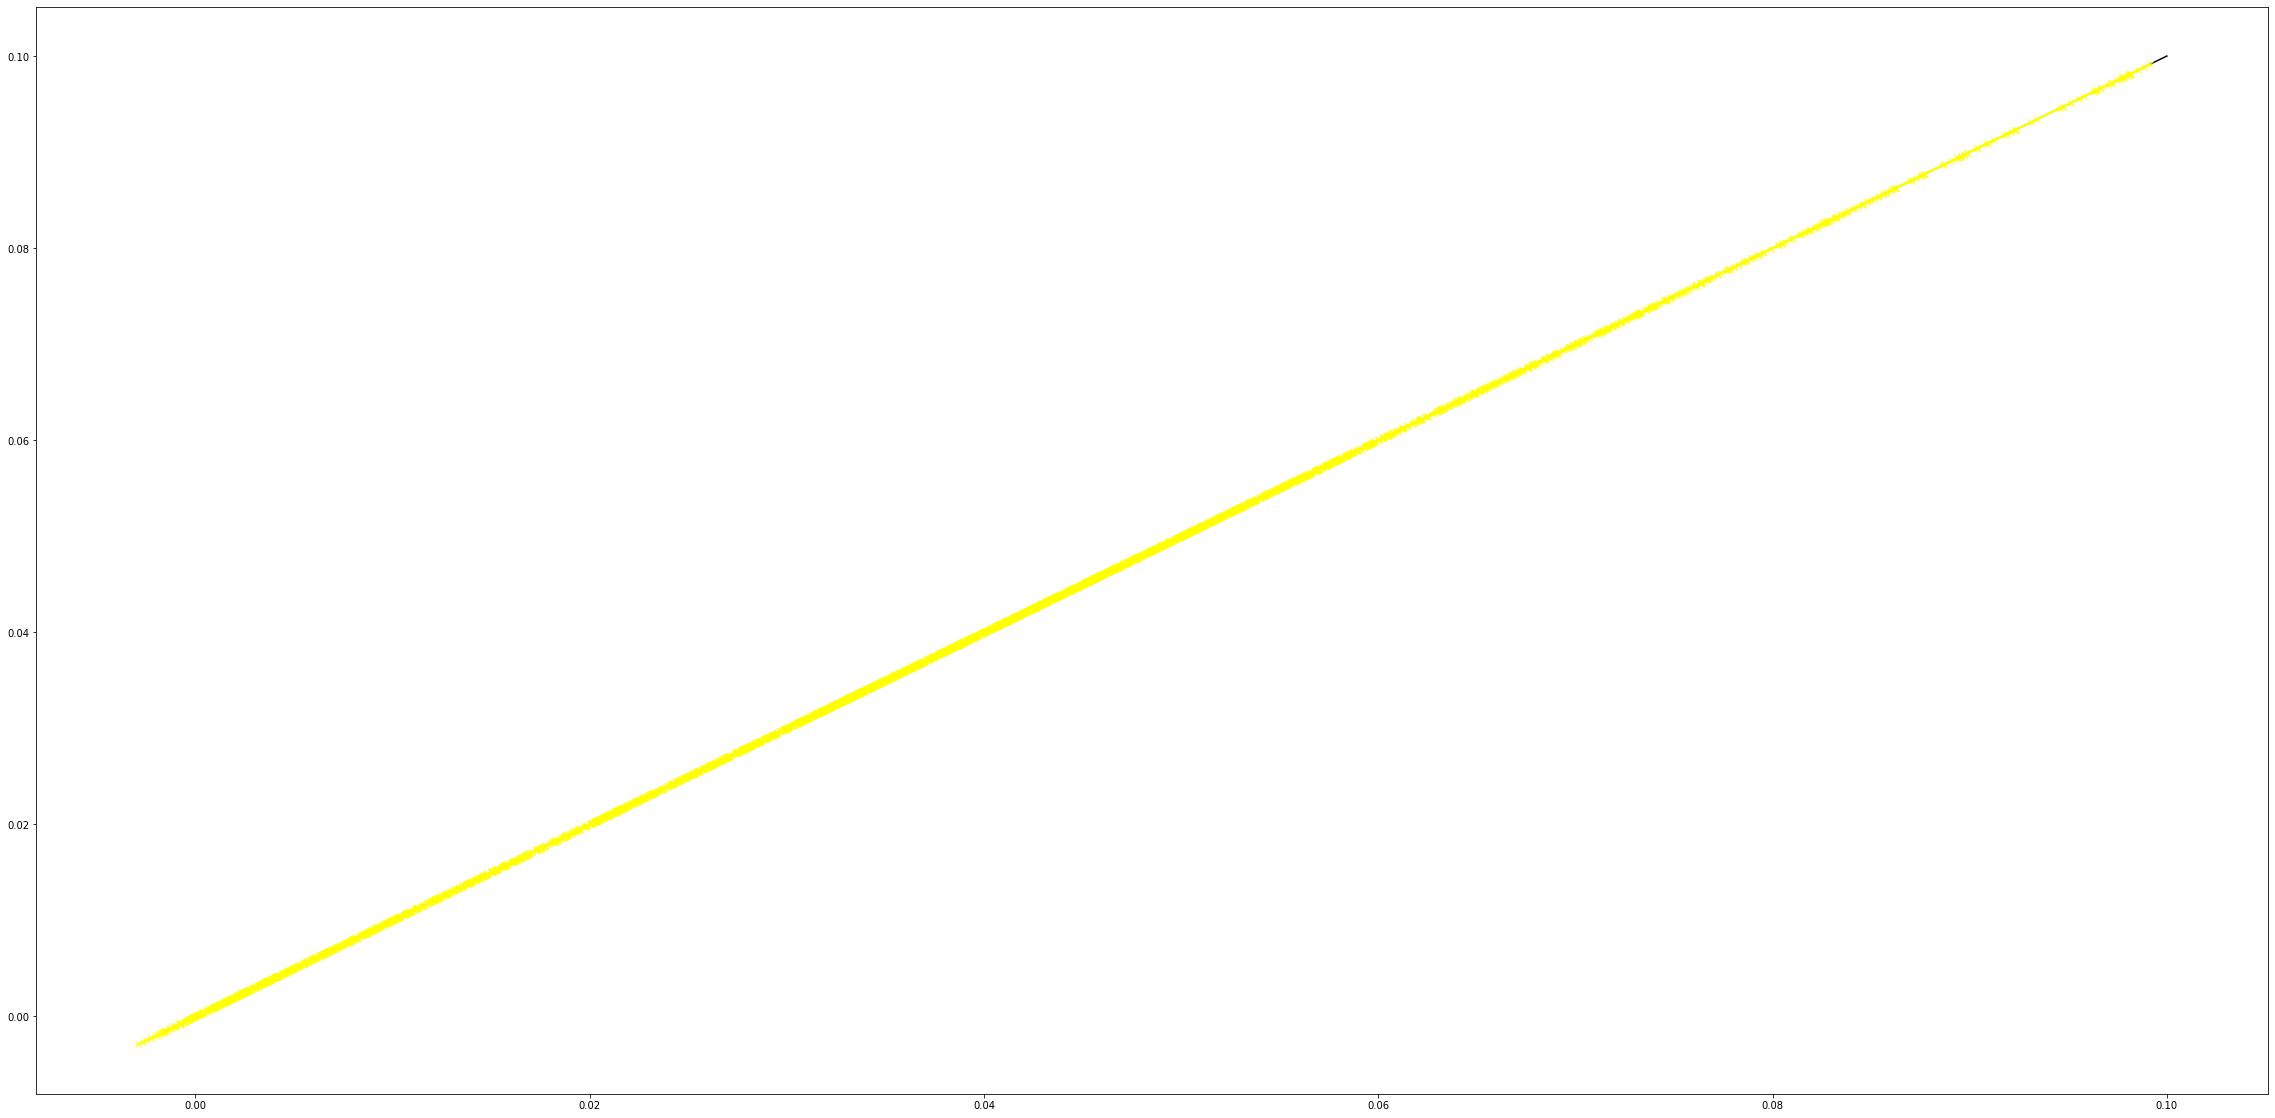

In [104]:
plt.figure(figsize=(40,20))
#for i in range(ae_reconstructed.shape[1]):
#    plt.scatter(ae_reconstructed[:, i], df.values[:, i], marker='.') # ae recon vs original data
#plt.legend(df.columns, markerscale=4, fontsize=20)
plt.plot(np.linspace(0,0.1,100),np.linspace(0,0.1,100),c='black') # y = x
plt.plot(pca_reconstructed, df_pca_recon, marker='x', c='yellow') # pca preimage vs original data
df.shape==ae_reconstructed.shape

In [159]:
np.std(ae_decoder_svd.T/pca_model.components_)

5.9688612315530705

In [15]:
mu = np.mean(df.values, axis=0)
ae_svd_projections = np.array(df.values-mu) @ ae_decoder_svd

In [16]:
np.max(ae_svd_projections - pca_model.transform(df))

0.19281327648523647

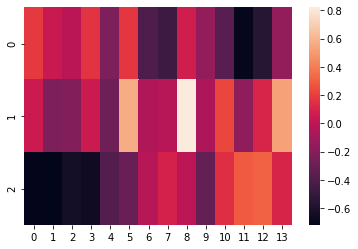

In [31]:
sns.heatmap(w2)

In [19]:
df_ae = pd.DataFrame(ae_svd_projections)
df_ae.index = df.index

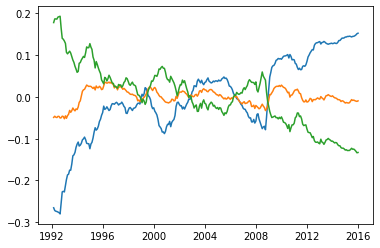

In [160]:
plt.plot(df_ae - df_pca)

Diagonalize the sample covariance matrix with the m-loading vectors:
$$\text{P}_m^T \text{Y}_0 \text{Y}_0^T \text{P}_m$$

The sample covariance matrix is given by C.

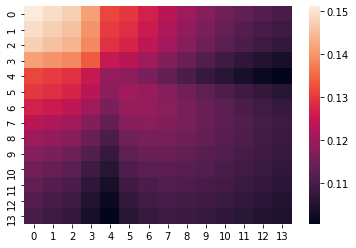

In [21]:
C = np.dot((df-mu).T, df-mu)
ax = sns.heatmap(C)

The total variance is given by the sum of the diagonal elements of the covariance matrix

In [22]:
print('total variance:', np.sum(np.diag(C)))

total variance: 1.7086096174655052


### Compare the transformed sample covariances
Begin with PCA

In [23]:
Lambda_from_pca = pca_model.components_ @ C @ pca_model.components_.T

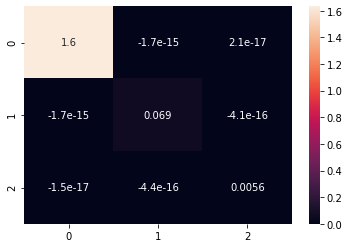

In [24]:
ax = sns.heatmap(Lambda_from_pca, annot=True)

Show the explained variances by each component (check with above)

In [25]:
total_variance = np.sum(np.diag(C))

print(100 * np.diag(Lambda_from_pca) / total_variance)

print('{:.6}% of total variance explained'.format(100 * np.sum(np.diag(Lambda_from_pca)) / total_variance))

[95.53366571  4.0667419   0.32890998]
99.9293% of total variance explained


Now perform the transformation of the covariance matrix using the decoder weights. Note that the matrix $\Lambda$ is no longer diagonal.

In [157]:
Lambda_from_decoder_weights = w2 @ C @ w2.T
np.matmul(w2,np.matmul(C, w2.T))

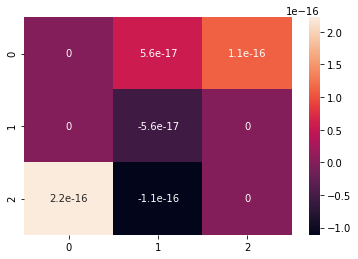

In [158]:
ax = sns.heatmap(Lambda_from_decoder_weights, annot=True)
plt.show()

Finally, perform the transformation of the covariance matrix using the left singular vectors of the decoder weights. Note that the matrix $\Lambda$ is diagonal.

In [162]:
Lambda_from_decoder_svd = ae_decoder_svd.T @ C @ ae_decoder_svd

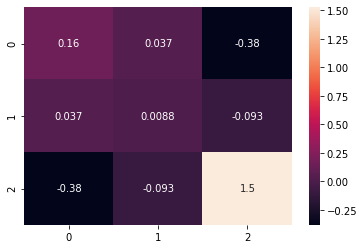

In [163]:
ax = sns.heatmap(Lambda_from_decoder_svd, annot=True)
plt.show()

Show the explained variances by each diagonal component and compare with PCA.

In [113]:
total_variance = np.sum(np.diag(C))
print(100*np.diag(Lambda_from_decoder_svd) / total_variance)
print('{:.6}% of total variance explained'.format(100*np.sum(np.diag(Lambda_from_decoder_svd)) / total_variance))

[ 2.74877953 32.21732831 64.63680186]
99.6029% of total variance explained


## Visualize the data projected onto the principal components
First show the data on the principal components obtained by PCA. Then show the data using the left singular vectors from the decoder weight matrix.

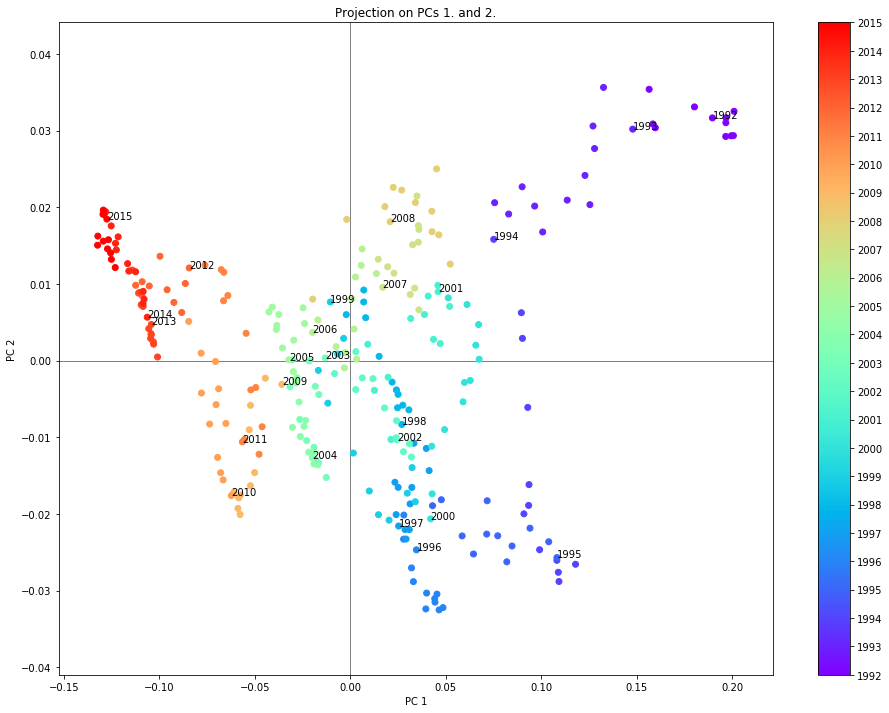

In [268]:
# plot the result
merged_years = 1
pc1 = 0
pc2 = 1
fig = plt.figure(figsize=(16,12))
plt.title('Projection on PCs {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey",linewidth=1.0,zorder=0)
    
sc = plt.scatter(df_pca.loc[:, pc1], df_pca.loc[:, pc2], c = [d.year for d in df_pca.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_pca.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_pca.index])[::1])

for year in range(df_pca.index.min().year, df_pca.index.max().year+1, merged_years):
    year_start = df_pca.index[df_pca.index.searchsorted(datetime(year, 1, 1))]
    year_end = df_pca.index[df_pca.index.searchsorted(datetime(year + merged_years-1, 12, 31))]
    
    plt.annotate('{0}'.format(year), xy=(df_pca.loc[year_start, pc1],df_pca.loc[year_start, pc2]), 
                 xytext=(df_pca.loc[year_start,pc1],df_pca.loc[year_start,pc2]))


Now show the data using the left singular vectors from the decoder weight matrix. Note that the sign of the first principal component has been changed for ease of comparison.

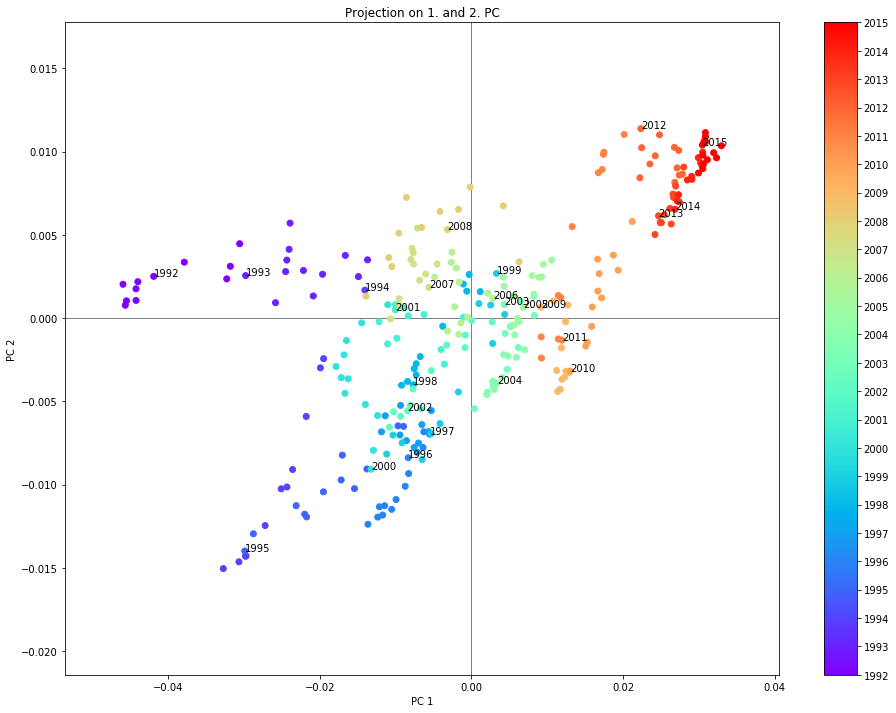

In [269]:
# plot the result
merged_years = 1
pc1 = 0
pc2 = 1
fig = plt.figure(figsize=(16, 12))
plt.title('Projection on {0}. and {1}. PC'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey", linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey", linewidth=1.0,zorder=0)
    
sc = plt.scatter(-df_ae.loc[:,pc1], df_ae.loc[:,pc2], c=[d.year for d in df_ae.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_ae.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_ae.index])[::1])

for year in range(df_ae.index.min().year, df_ae.index.max().year+1, merged_years):
    year_start = df_ae.index[df_ae.index.searchsorted(datetime(year,1,1))]
    year_end = df_ae.index[df_ae.index.searchsorted(datetime(year+merged_years-1,12,31))]
    plt.annotate('{0}'.format(year), xy=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]), xytext=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]))

    #plt.annotate('{0}'.format(year), xy=df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]), xytext=(df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]))

None

### Plot the reconstruction error of the linear autoencoder

In [ ]:
y_hat_l=ae.predict(df)
plt.figure(figsize=(20,15))
plt.plot(df.index, pd.DataFrame(y_hat_l-df))
plt.xlim(df.index.min(), df.index.max())
# plt.ylim(0, 0.1)
plt.ylim(-0.008, 0.008)
plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(pd.datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

### Deep Autoencoders

In [314]:
# Deep Autoencoder
def DeepAE(y, dimension, learning_rate = 1e-4, regularization = 5e-4, epochs=10):
    input = Input(shape=(y.shape[1],))
    encoded1 = Dense(np.int(2*dimension), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(input)
    encoded2 = Dense(dimension, activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded1)
    decoded1 = Dense(np.int(y.shape[1]/2), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded2)
    decoded2 = Dense(y.shape[1], activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(decoded1)
    autoencoder = models.Model(input, decoded2)
    autoencoder.compile(optimizer=optimizers.adam(lr=learning_rate), loss='mean_squared_error')
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

In [315]:
deepAE_model = DeepAE(df, 3, regularization=0, epochs=5)

Epoch 1/5
287/287 [==============================] - 2s 9ms/step - loss: 0.0013
Epoch 2/5
287/287 [==============================] - 0s 1ms/step - loss: 8.1686e-04
Epoch 3/5
287/287 [==============================] - 1s 2ms/step - loss: 5.7136e-04
Epoch 4/5
287/287 [==============================] - 1s 2ms/step - loss: 4.3700e-04
Epoch 5/5
287/287 [==============================] - 1s 2ms/step - loss: 3.6482e-04


### Plot the reconstruction error of the linear autoencoder by variable

/Users/Dez/anaconda3/envs/malfoy/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':


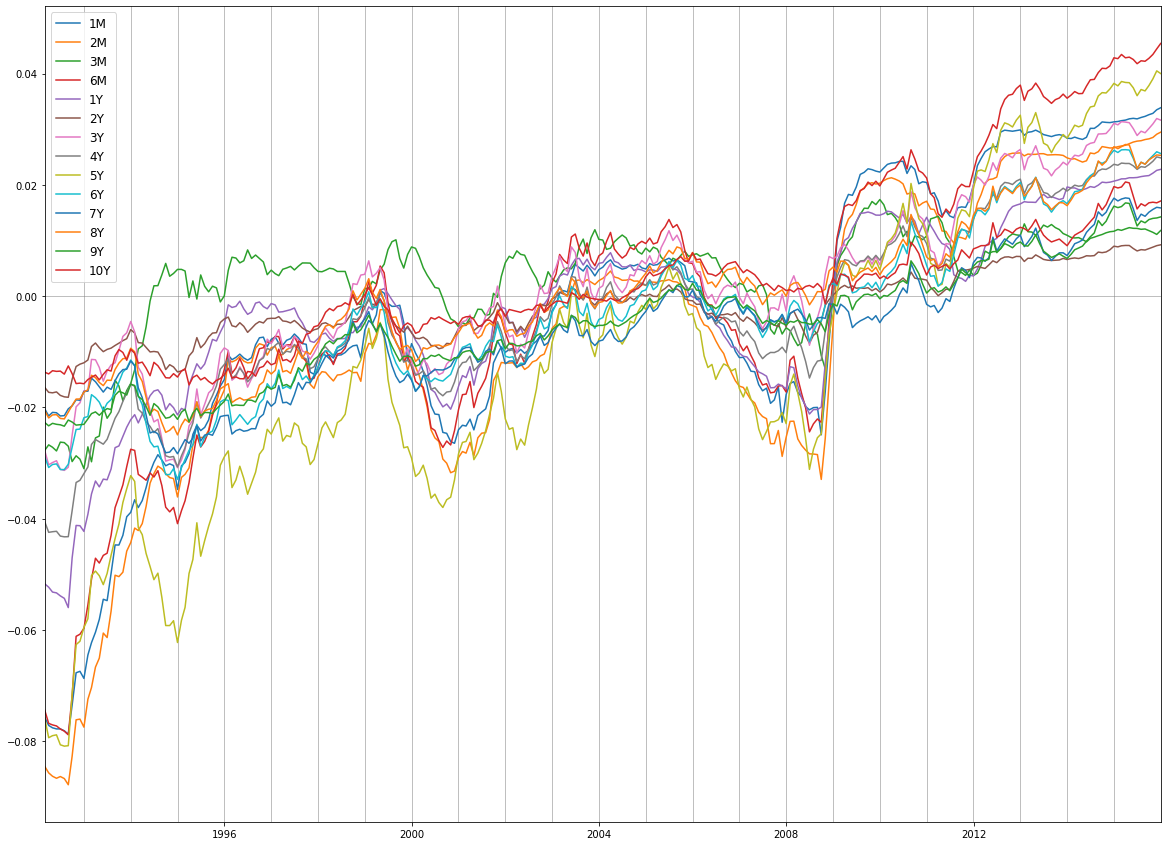

In [321]:
y_hat_d=deepAE_model.predict(df)
plt.figure(figsize=(20,15))
plt.plot(df.index, pd.DataFrame(y_hat_d-df))
plt.xlim(df.index.min(), df.index.max())
plt.legend(df.columns, fontsize=12)
#plt.ylim(-0.008, 0.008)
plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(pd.datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)